In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE 
import local_python_packages.features_adding as local

In [2]:
pd.set_option('display.max_columns', None)
flights_data = pd.read_csv('All flights 2019_final.csv',parse_dates=[0])
flights_data = flights_data.sort_values(['fl_date'])

In [3]:
df_weather = pd.read_csv('cities_and_dates_weather_final.csv',parse_dates=[1])

In [4]:
df_holidays = pd.read_csv('US holidays.csv',parse_dates=[0])

Adding additional columns from our feature engineering

In [5]:
flights_data = local.add_taxi_Ndays_rolling(flights_data, 7, 7)

In [6]:
flights_data = local.add_traffic_rolling(flights_data, 7, 7)

In [7]:
flights_data = local.make_month_dummies(flights_data, 'fl_date')

In [8]:
flights_data = local.merging_weather_flights(flights_data,df_weather)

In [9]:
flights_data = local.add_dep_delay_Ndays_rolling(flights_data, 7, 7)

In [10]:
flights_data = local.add_dep_delay_Ndays_roll_per_tail_num(flights_data, 7, 7)

In [11]:
flights_data = local.add_US_holidays(flights_data, df_holidays)

In [12]:
flights_data = local.make_dates_ordinal(flights_data, 'fl_date')

In [13]:
flights_data = local.add_arr_delay_Ndays_roll(flights_data, 7, 7, ['origin_airport_id', 'dest_airport_id', 'tail_num',
                                                                   'mkt_carrier_fl_num' ])

In [14]:
flights_data = local.add_polynomial_features(flights_data)

In [19]:
features_list = [
        #From initial dataset
        'fl_date', 'arr_delay', 'crs_elapsed_time','air_time', 'distance',
        
        #From add_taxi_Ndays_rolling function
       '7d taxi_out by origin_airport_id', '7d taxi_in by dest_airport_id', 
        '7d taxi_out by mkt_carrier_fl_num', '7d taxi_in by mkt_carrier_fl_num',
        
        #From add_traffic_rolling function
       '7d roll flts origin_airport_id', '7d roll flts dest_airport_id',
        
        #From make_month_dummies function
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 
        'month_6','month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
        
        #From merging_weather_flights function
       'origin_city_wspd', 'origin_visibility',
       'dest_city_wspd', 'dest_visibility',
        'origin_cond_Overcast', 'origin_cond_Partially cloudy', 'origin_cond_Rain', 'origin_cond_Snow',
       'dest_cond_Overcast', 'dest_cond_Partially cloudy', 'dest_cond_Rain','dest_cond_Snow',
        'origin_wspd/visib', 'dest_wspd/visib',
        
        #From add_US_holidays function
        'Type_Federal holiday',
        
        #From add_dep_delay_Ndays_rolling function
        '7 days roll dep_delay', 
        
        #From add_dep_delay_Ndays_roll_per_tail_num function
        '7 days roll dep_delay_per_tail_num',
        
        #From add_polynomial_features function
        'dest_air X date' , 'orig_air X date',
        'mkt_carrier_fl_num X date', 'tail_num X date',
        'tail_num X dest airport', 'tail_num X origin airport',  'mkt_carrier X dest_airport', 'mkt_carrier X origin_airport',
        '7d roll taxi_out X tail_num', '7d roll taxi_in X tail_num',
        
        #From add_arr_delay_Ndays_roll function
        '7 days roll arr_delay_per_origin_airport_id', '7 days roll arr_delay_per_dest_airport_id', 
        '7 days roll arr_delay_per_tail_num', '7 days roll arr_delay_per_mkt_carrier_fl_num']

In [20]:
flights_data = local.replace_nan_with_mean(flights_data, 'arr_delay')

In [21]:
flights_data.head()

,fl_date,mkt_carrier,mkt_carrier_fl_num,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,cancelled,cancellation_code,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name,7d taxi_out by origin_airport_id,7d taxi_in by dest_airport_id,7d taxi_out by mkt_carrier_fl_num,7d taxi_in by mkt_carrier_fl_num,7d roll flts origin_airport_id,7d roll flts dest_airport_id,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,origin_city_wspd,origin_visibility,origin_wspd/visib,dest_city_wspd,dest_visibility,dest_wspd/visib,origin_cond_Overcast,origin_cond_Partially cloudy,origin_cond_Rain,origin_cond_Snow,dest_cond_Overcast,dest_cond_Partially cloudy,dest_cond_Rain,dest_cond_Snow,7 days roll dep_time,7 days roll dep_delay_per_tail_num,Type_Federal holiday,7 days roll arr_delay_per_origin_airport_id,7 days roll arr_delay_per_dest_airport_id,7 days roll arr_delay_per_tail_num,7 days roll arr_delay_per_mkt_carrier_fl_num,orig_air X date,dest_air X date,mkt_carrier_fl_num X date,tail_num X date,tail_num X dest airport,tail_num X origin airport,mkt_carrier X dest_airport,mkt_carrier X origin_airport,7d roll taxi_out X tail_num,7d roll taxi_in X tail_num
0,737060,UA,3683,N751YX,3683,13487,MSP,"Minneapolis, MN",12266,IAH,"Houston, TX",530,527.0,-3.0,31.0,558.0,842.0,8.0,835,850.0,15.0,0.0,NaN,0.0,N,185.0,203.0,164.0,1.0,1034.0,0.0,0.0,15.0,0.0,0.0,NaN,NaN,NaN,NaN,16.347962,6.023810,21.988095,11.142857,15.285714,3.000000,1,0,0,0,0,0,0,0,0,0,0,0,24.2,16.0,1.512180,18.4,12.0,1.532889,0,0,0,0,0,1,0,0,12.502838,23.404762,1,8.440900,7.083333,22.464286,-0.785714,9940728220,9040777960,2714591980,-5876437948029505976,-8958774546702137904,-8306064417713355976,45175678,49672621,1.312062e+17,4.834615e+16
1,737060,DL,1971,N847DN,1971,14869,SLC,"Salt Lake City, UT",11433,DTW,"Detroit, MI",931,928.0,-3.0,21.0,949.0,1447.0,9.0,1503,1456.0,-7.0,0.0,NaN,0.0,N,212.0,208.0,178.0,1.0,1481.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.273368,5.310005,18.952381,7.404762,89.714286,50.857143,1,0,0,0,0,0,0,0,0,0,0,0,14.1,16.0,0.881324,27.6,14.7,1.876954,0,1,0,1,0,1,1,0,22.987325,8.400000,1,18.228686,3.259983,0.078571,-10.047619,10959345140,8426806980,1452745260,-5876437948029505976,-2273143371154838136,5470827911421647848,22534443,29306799,1.145558e+17,4.261727e+16
2,737060,DL,2039,N812DN,2039,14771,SFO,"San Francisco, CA",10397,ATL,"Atlanta, GA",2245,2240.0,-5.0,17.0,2257.0,603.0,6.0,620,609.0,-11.0,0.0,NaN,0.0,N,275.0,269.0,246.0,1.0,2139.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.441872,3.868603,15.908163,6.842687,37.428571,33.000000,1,0,0,0,0,0,0,0,0,0,0,0,32.5,16.0,2.030606,9.4,13.8,0.681390,0,1,0,0,0,1,1,0,11.668305,4.964286,1,8.501651,21.601883,1.116667,-0.876701,10887113260,7663212820,1502865340,-5876437948029505976,-1708973536738680280,-8934063540392418216,21199483,30118069,1.078824e+17,3.104880e+16
3,737060,DL,1972,N339NB,1972,10423,AUS,"Austin, TX",12478,JFK,"New York, NY",805,805.0,0.0,14.0,819.0,1208.0,7.0,1237,1215.0,-22.0,0.0,NaN,0.0,N,212.0,190.0,169.0,1.0,1521.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.428571,5.365101,12.642857,7.059524,2.000000,92.571429,1,0,0,0,0,0,0,0,0,0,0,0,22.2,13.9,1.596693,20.6,15.0,1.373085,0,1,0,0,0,1,1,0,-9.500000,9.107143,1,-20.928571,11.865841,4.614286,-2.928571,7682376380,9197034680,1453482320,-5876437948029505976,-385022516707894928,-6922407595829422728,24606616,20554156,9.172393e+16,4.305946e+16
4,737060,DL,5890,N202JQ,5890,11066,CMH,"Columbus, OH",12953,LGA,"New York, NY",1207,1158.0,-9.0,13.0,1211.0,1324.0,6.0,1349,1330.0,-19.0,0.0,NaN,0.0,N,102.0,92.0,73.0,1.0,479.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.216591,5.540921,18.523810,15.785714,709.428571,13.000000,1,0,0,0,0,0,0,0,0,0,0

In [22]:
flights_data = flights_data[features_list]

In [23]:
#flights_data = flights_data.dropna()

In [24]:
features_list.remove('arr_delay')

In [25]:
X = flights_data[features_list]
y = flights_data['arr_delay']

In [26]:
scaler = StandardScaler()

In [27]:
X = scaler.fit_transform(X)

In [28]:
X_train, X_test, y_train, y_test = local.quick_split(X,y,train_ratio=0.75)

In [29]:
# xgb_r = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=3438,
#     random_state=17,    
#     verbosity=1,
#     n_jobs=5,
#     booster='gbtree'
# )    

In [30]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [31]:
params = {
    # Parameters that we are going to tune.
    'max_depth':10,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 0.5,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':'mae',
    'booster':'gbtree',
    'random_state':17,
    'verbosity':1,
    'n_jobs':5
}

In [32]:
num_boost_round=999

In [33]:
xgb_r = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=30
)

[0]	Test-mae:23.10740
[1]	Test-mae:23.25806
[2]	Test-mae:23.44677
[3]	Test-mae:23.53321
[4]	Test-mae:23.61387
[5]	Test-mae:23.66853
[6]	Test-mae:23.71343
[7]	Test-mae:23.65865
[8]	Test-mae:23.66738
[9]	Test-mae:23.67387
[10]	Test-mae:23.48960
[11]	Test-mae:23.41299
[12]	Test-mae:23.28634
[13]	Test-mae:23.25254
[14]	Test-mae:23.23826
[15]	Test-mae:23.17669
[16]	Test-mae:23.14029
[17]	Test-mae:23.09451
[18]	Test-mae:23.06283
[19]	Test-mae:23.05158
[20]	Test-mae:23.03860
[21]	Test-mae:23.03067
[22]	Test-mae:23.00706
[23]	Test-mae:22.97816
[24]	Test-mae:22.96791
[25]	Test-mae:22.92231
[26]	Test-mae:22.89353
[27]	Test-mae:22.88251
[28]	Test-mae:22.87769
[29]	Test-mae:22.86105
[30]	Test-mae:22.84945
[31]	Test-mae:22.83676
[32]	Test-mae:22.83076
[33]	Test-mae:22.80409
[34]	Test-mae:22.79995
[35]	Test-mae:22.78304
[36]	Test-mae:22.74405
[37]	Test-mae:22.73485
[38]	Test-mae:22.72976
[39]	Test-mae:22.71452
[40]	Test-mae:22.70989
[41]	Test-mae:22.69290
[42]	Test-mae:22.68367
[43]	Test-mae:22.6743

In [34]:
y_pred = xgb_r.predict(dtest) 

In [35]:
rmse = np.sqrt(MSE(y_test, y_pred)) 
print("RMSE : % f" %(rmse)) 


RMSE :  48.165903


In [36]:
r2_score(y_test, y_pred)

0.11123349153683737

In [37]:
xgb_r.save_model('model_xgboost.json')

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

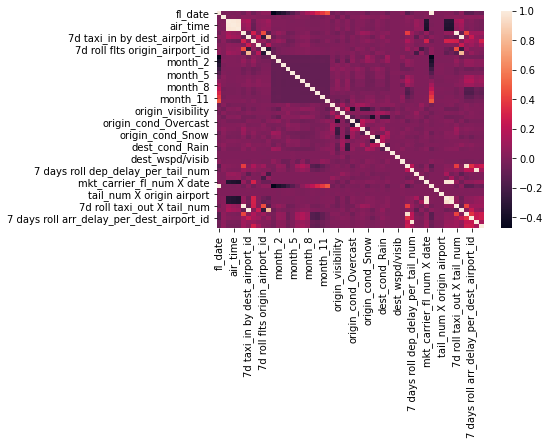

In [39]:
corr=flights_data.corr()
sns.heatmap(corr)

In [40]:
corr

,fl_date,arr_delay,crs_elapsed_time,air_time,distance,7d taxi_out by origin_airport_id,7d taxi_in by dest_airport_id,7d taxi_out by mkt_carrier_fl_num,7d taxi_in by mkt_carrier_fl_num,7d roll flts origin_airport_id,7d roll flts dest_airport_id,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,origin_city_wspd,origin_visibility,dest_city_wspd,dest_visibility,origin_cond_Overcast,origin_cond_Partially cloudy,origin_cond_Rain,origin_cond_Snow,dest_cond_Overcast,dest_cond_Partially cloudy,dest_cond_Rain,dest_cond_Snow,origin_wspd/visib,dest_wspd/visib,Type_Federal holiday,7 days roll dep_time,7 days roll dep_delay_per_tail_num,dest_air X date,orig_air X date,mkt_carrier_fl_num X date,tail_num X date,tail_num X dest airport,tail_num X origin airport,mkt_carrier X dest_airport,mkt_carrier X origin_airport,7d roll taxi_out X tail_num,7d roll taxi_in X tail_num,7 days roll arr_delay_per_origin_airport_id,7 days roll arr_delay_per_dest_airport_id,7 days roll arr_delay_per_tail_num,7 days roll arr_delay_per_mkt_carrier_fl_num
fl_date,1.000000,-0.017686,-0.005846,-0.009668,-0.000775,-0.041117,0.038114,-0.051690,0.013685,0.050325,0.050336,-0.475004,-0.372065,-0.320968,-0.227605,-0.141988,-0.051500,0.040014,1.319491e-01,0.214860,0.309903,0.387859,0.476395,-0.045473,-0.004318,-0.045201,-0.004310,-0.011412,-0.017808,0.004962,-0.057077,-0.011408,-0.017741,0.004990,-0.057273,-0.002956,-0.002948,0.037132,-0.131667,-0.051955,-0.001013,-1.216781e-03,0.008980,1.000000,-0.001572,-0.001656,0.008534,0.008494,-0.041117,0.038114,-0.134039,-0.126958,-0.056391,-0.067970
arr_delay,-0.017686,1.000000,-0.006259,0.009340,-0.007814,0.040332,0.027560,0.036073,0.015830,0.017468,0.009712,-0.005886,0.017949,-0.012631,-0.005881,0.007866,0.036626,0.019045,1.231513e-02,-0.029590,-0.017184,-0.029011,0.005614,0.031353,-0.053813,0.032401,-0.050710,0.014436,0.011104,0.049878,0.035158,0.016010,0.011137,0.052880,0.027445,0.002017,0.002063,-0.001563,0.046998,0.036940,0.000841,-7.099103e-03,0.022446,-0.017686,0.001416,0.000946,0.022180,0.020841,0.040332,0.027560,0.050019,0.054272,0.042252,0.053218
crs_elapsed_time,-0.005846,-0.006259,1.000000,0.989236,0.982550,0.121568,0.153984,-0.049960,0.054827,0.068201,0.112338,0.005872,0.005855,0.006300,-0.000026,-0.004082,-0.000875,-0.000126,-3.326007e-03,-0.011551,-0.008907,0.000020,0.011578,-0.025806,0.020583,-0.009632,0.026273,-0.022519,0.014413,0.020223,-0.007770,-0.021871,0.021387,0.004093,-0.015529,-0.002300,-0.002074,0.004437,0.031411,0.006126,0.082935,5.071975e-02,-0.331910,-0.005846,0.001251,0.000903,-0.317387,-0.320218,0.121568,0.153984,0.001378,0.014906,-0.015290,-0.028538
air_time,-0.009668,0.009340,0.989236,1.000000,0.983560,0.080572,0.122244,-0.073543,0.040243,0.055902,0.087666,0.004117,0.006974,0.006771,0.002118,-0.000334,0.002628,-0.000743,-4.375008e-03,-0.013068,-0.008327,-0.002406,0.007382,-0.019059,0.020437,-0.002985,0.023314,-0.021994,0.013416,0.017316,-0.010744,-0.018285,0.022121,0.007397,-0.015299,-0.002047,-0.001794,0.003685,0.020437,0.001097,0.090726,5.250810e-02,-0.348928,-0.009668,0.001628,0.000900,-0.332827,-0.336867,0.080572,0.122244,-0.004735,0.007644,-0.019470,-0.029425
distance,-0.000775,-0.007814,0.982550,0.983560,1.000000,0.058037,0.106556,-0.088034,0.034249,0.072523,0.072304,-0.002143,-0.002073,0.004039,-0.000420,-0.001309,0.004456,0.005915,1.122229e-03,-0.006721,-0.005517,-0.002278,0.004475,-0.014321,0.032815,-0.014450,0.032670,-0.024965,0.016787,0.002593,-0.019720,-0.024815,0.016616,0.002616,-0.019682,-0.002271,-0.002275,0.003698,0.009858,-0.000947,0.071292,7.104915e-02,-0.365567,-0.000775,0.000885,0.000862,-0.351315,-0.351313,0.058037,0.106556,-0.014147,0.005434,-0.022755,-0.033258
7d taxi_out by origin_airport_id,-0.041117,0.040332,0.121568,0.080572,0.058037,1.000000,-0.084568,0.285437,0.007995,0.451817,-0.132569,0.025683,0.075709,0.033307,-0.050470,-0.039540,0.000321,0.006632,2.064204e-02,-0.030103,-0.036362,-0.016780,0.016151,-0.022557,-0.051424,0.

In [41]:
corr.loc['arr_delay', :].abs().sort_values( ascending = False)

arr_delay                                       1.000000
7 days roll arr_delay_per_dest_airport_id       0.054272
origin_visibility                               0.053813
7 days roll arr_delay_per_mkt_carrier_fl_num    0.053218
dest_cond_Rain                                  0.052880
dest_visibility                                 0.050710
7 days roll arr_delay_per_origin_airport_id     0.050019
origin_cond_Rain                                0.049878
7 days roll dep_time                            0.046998
7 days roll arr_delay_per_tail_num              0.042252
7d taxi_out by origin_airport_id                0.040332
7d roll taxi_out X tail_num                     0.040332
7 days roll dep_delay_per_tail_num              0.036940
month_6                                         0.036626
7d taxi_out by mkt_carrier_fl_num               0.036073
origin_cond_Snow                                0.035158
dest_city_wspd                                  0.032401
origin_city_wspd               